In [1]:
!pip install torch torchvision
!pip install matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import os
import time
import matplotlib.pyplot as plt

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Create models
teacher = SimpleCNN().to(device)
student = SimpleCNN().to(device)


In [3]:
# Data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True)
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False)

# Define a distillation loss
def distillation_loss(student_outputs, teacher_outputs, labels, temperature, alpha):
    soft_target_loss = nn.KLDivLoss()(F.log_softmax(student_outputs/temperature, dim=1),
                                      F.softmax(teacher_outputs/temperature, dim=1)) * temperature * temperature

    hard_target_loss = nn.CrossEntropyLoss()(student_outputs, labels)

    loss = alpha * soft_target_loss + (1. - alpha) * hard_target_loss
    return loss


100%|██████████| 170498071/170498071 [00:11<00:00, 14834265.98it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
optimizer_teacher = optim.SGD(teacher.parameters(), lr=0.001, momentum=0.9)

epochs_teacher = 2  # 50
for epoch in range(epochs_teacher):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer_teacher.zero_grad()

        outputs = teacher(inputs)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        loss.backward()
        optimizer_teacher.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

torch.save(teacher.state_dict(), 'teacher.pth')
print('Finished Training Teacher')


[1,  2000] loss: 2.123
[1,  4000] loss: 1.764
[1,  6000] loss: 1.607
[1,  8000] loss: 1.489
[1, 10000] loss: 1.448
[1, 12000] loss: 1.347
[2,  2000] loss: 1.265
[2,  4000] loss: 1.235
[2,  6000] loss: 1.185
[2,  8000] loss: 1.166
[2, 10000] loss: 1.124
[2, 12000] loss: 1.125
Finished Training Teacher


In [5]:
# Student Model Training with Distillation (for demo)
optimizer_student = optim.SGD(student.parameters(), lr=0.001, momentum=0.9)

epochs_student = 2  #50
alpha = 0.1
temperature = 3.0

teacher.load_state_dict(torch.load('teacher.pth'))
teacher.eval()  # Ensure teacher is in eval mode

for epoch in range(epochs_student):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer_student.zero_grad()

        # Forward pass of the teacher with no gradients
        with torch.no_grad():
            teacher_outputs = teacher(inputs)

        # Forward pass of the student
        student_outputs = student(inputs)

        # Compute the distillation loss
        loss = distillation_loss(student_outputs, teacher_outputs, labels, temperature, alpha)

        # Backward and optimize
        loss.backward()
        optimizer_student.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training Student')


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2919: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


[1,  2000] loss: 1.963
[1,  4000] loss: 1.650
[1,  6000] loss: 1.476
[1,  8000] loss: 1.379
[1, 10000] loss: 1.303
[1, 12000] loss: 1.273
[2,  2000] loss: 1.161
[2,  4000] loss: 1.116
[2,  6000] loss: 1.093
[2,  8000] loss: 1.040
[2, 10000] loss: 1.027
[2, 12000] loss: 0.983
Finished Training Student


In [6]:
def evaluate_model(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []

    start_time = time.time()
    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
    end_time = time.time()

    labels = np.concatenate(all_labels)
    preds = np.concatenate(all_preds)

    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted')
    recall = recall_score(labels, preds, average='weighted')
    f1 = f1_score(labels, preds, average='weighted')

    print(f'Accuracy: {acc}, Precision: {precision}, Recall: {recall}, F1: {f1}')
    print(f'Inference time for the whole dataset: {end_time - start_time} seconds')

    return acc, precision, recall, f1, end_time - start_time

# Calculate and compare metrics
print("Teacher Metrics: ")
teacher_metrics = evaluate_model(teacher, testloader)

print("Student Metrics: ")
student_metrics = evaluate_model(student, testloader)


Teacher Metrics: 
Accuracy: 0.6301, Precision: 0.6467044580010006, Recall: 0.6301, F1: 0.628446433914725
Inference time for the whole dataset: 9.770039796829224 seconds

Student Metrics: 
Accuracy: 0.6362, Precision: 0.6569336232681444, Recall: 0.6362, F1: 0.6350914019781874
Inference time for the whole dataset: 8.947579860687256 seconds



Teacher model size: 2.22 MB
Student model size: 2.22 MB


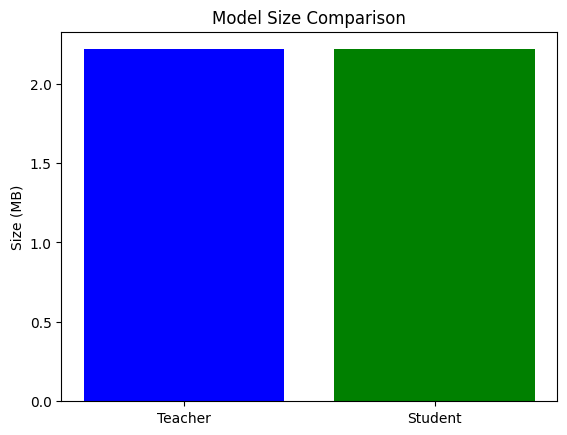

In [8]:
# Save model weights
torch.save(teacher.state_dict(), 'teacher.pth')
torch.save(student.state_dict(), 'student.pth')

# Check model sizes
teacher_size = os.path.getsize('teacher.pth') / 1e6  # Convert bytes to MB
student_size = os.path.getsize('student.pth') / 1e6

print(f'\nTeacher model size: {teacher_size:.2f} MB')
print(f'Student model size: {student_size:.2f} MB')

# Labels and values for plotting
labels = ['Teacher', 'Student']
sizes = [teacher_size, student_size]

# Create a bar plot
plt.bar(labels, sizes, color=['blue', 'green'])
plt.ylabel('Size (MB)')
plt.title('Model Size Comparison')
plt.show()


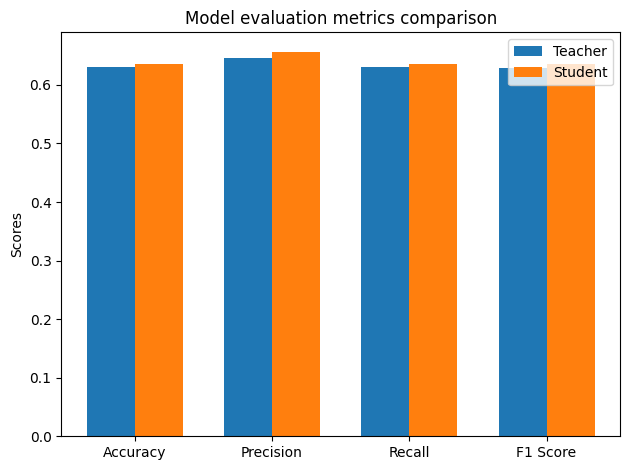

In [10]:
labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
teacher_eval = teacher_metrics[:4]
student_eval = student_metrics[:4]

x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, teacher_eval, width, label='Teacher')
rects2 = ax.bar(x + width/2, student_eval, width, label='Student')

ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()


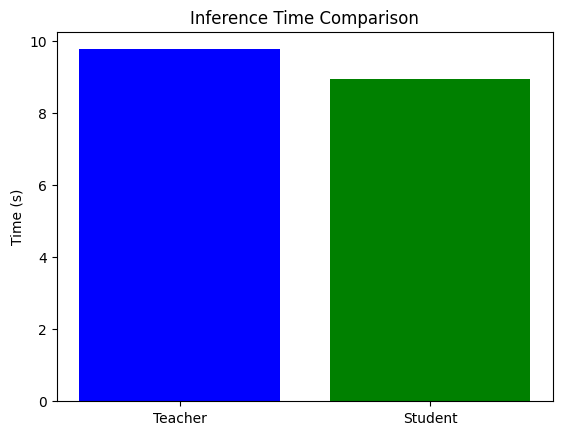

In [11]:
labels = ['Teacher', 'Student']
times = [teacher_metrics[-1], student_metrics[-1]]  # Assuming the last metric is time

plt.bar(labels, times, color=['blue', 'green'])
plt.ylabel('Time (s)')
plt.title('Inference Time Comparison')
plt.show()
